# Using SVD to Analyse Spatio-temporal Patterns in Atmospheric Pressure.

Atmospheric Pressure on a 20x20 grid over a certain region in space for 25 time steps (t=0 to t=24)

Loading and visualizing the data for each timestep:

In [2]:
# Loading and Visualizing the data

import h5py
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
filename = 'atm_pressure_dataset.h5'

with h5py.File(filename, "r") as f:
    a_group_key = list(f.keys())[0]
    data = np.array(f[a_group_key])

print("Shape: ",np.shape(data))

Shape:  (25, 20, 20)


The data provided actually gives the dipole structure in vertical while the in the video it was horizontal, hence before going further the matrix is rotated by $90^0$

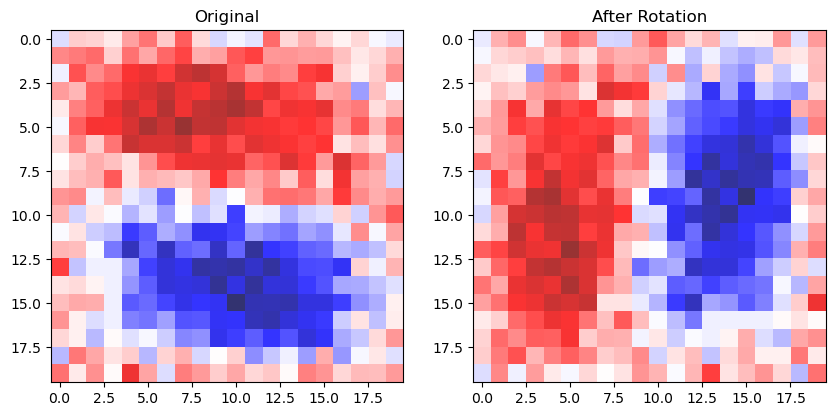

Original Matrix
[[-1.14 -0.05 -0.13 ... -0.17 -0.8  -0.96]
 [ 0.86  1.    1.24 ... -0.37 -0.2   0.33]
 [-0.87  1.56  0.82 ... -0.52 -0.07  0.78]
 ...
 [-0.18 -0.5  -1.6  ... -1.41 -0.21  0.66]
 [-1.59  1.07  0.43 ... -0.78 -0.4  -1.08]
 [ 1.13 -0.43  0.72 ...  0.18  0.14  0.59]]

Rotated matrix
[[-0.96  0.33  0.78 ...  0.66 -1.08  0.59]
 [-0.8  -0.2  -0.07 ... -0.21 -0.4   0.14]
 [-0.17 -0.37 -0.52 ... -1.41 -0.78  0.18]
 ...
 [-0.13  1.24  0.82 ... -1.6   0.43  0.72]
 [-0.05  1.    1.56 ... -0.5   1.07 -0.43]
 [-1.14  0.86 -0.87 ... -0.18 -1.59  1.13]]


In [3]:
plt.rcParams['figure.figsize'] = [10, 10]
f, ax = plt.subplots(1,2)
ax[0].imshow(data[3], alpha = 0.8, cmap = 'seismic')
ax[0].set_title("Original")
ax[1].imshow(np.rot90(data[3]), alpha = 0.8, cmap = 'seismic')
ax[1].set_title("After Rotation")
plt.show()

with np.printoptions(precision=2, suppress=True, threshold=5):
    print('Original Matrix')
    print(data[3])
    print()
    print('Rotated matrix')
    print(np.rot90(data[3]))

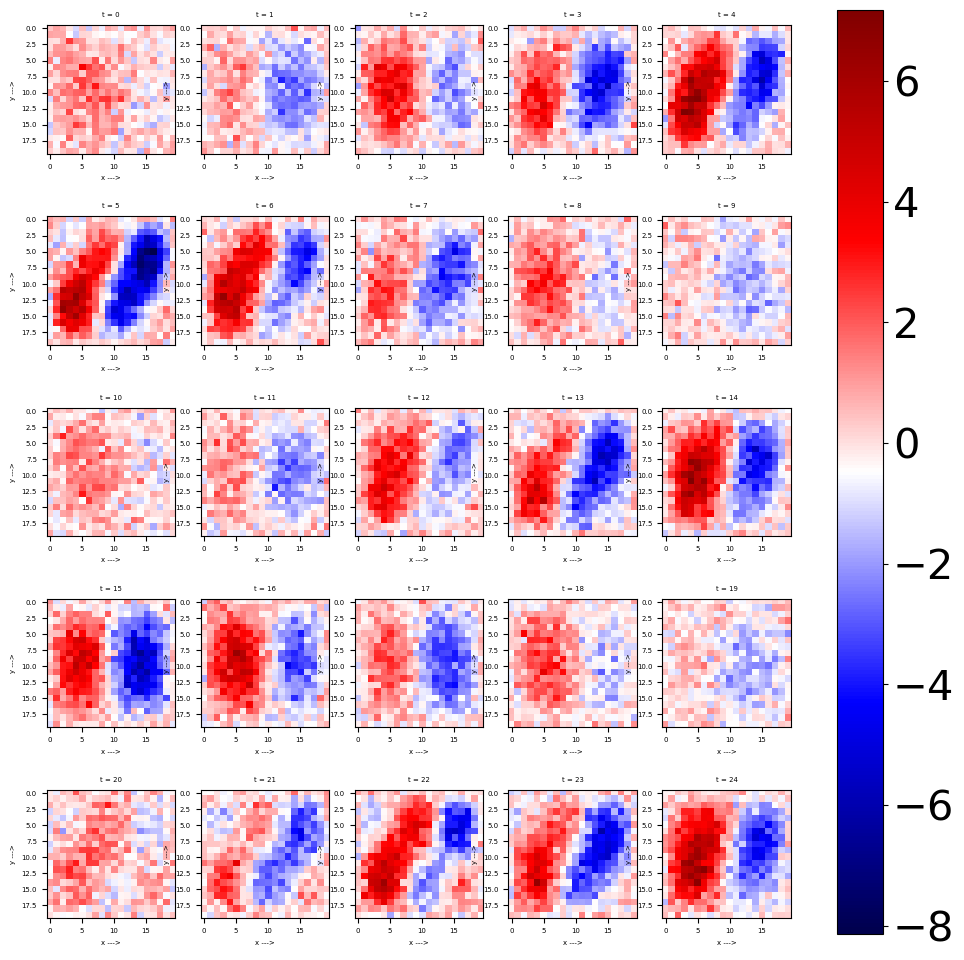

In [4]:
for i in range(25):
    data[i] = np.rot90(data[i])


plt.rcParams['figure.figsize'] = [12, 12]

fig, axes = plt.subplots(nrows=5, ncols=5) 

timestep = 0

#Creating subplots for each timestep
for ax in axes.flat: 
    im = ax.imshow(data[timestep],
                   vmin=np.min(data), 
                   vmax=np.max(data), 
                   cmap = 'seismic') 
    ax.tick_params(axis='both', which='major', labelsize=5)
    ax.tick_params(axis='both', which='minor', labelsize=5)
    ax.set_title("t = " + str(timestep), fontsize = '5')
    ax.set_xlabel("x --->",fontsize = "5")
    ax.set_ylabel("y --->",fontsize = "5")
    timestep = timestep+1
  
cbar = plt.colorbar(im, ax=axes.ravel().tolist()) 
cbar.ax.tick_params(labelsize=30)
plt.show()

We can see that there is a dipolar pattern in some of the images, but the strength is varying.

To find the how the spatial patterns are changing with time we need to flatten the 25x20x20 data into 25x400 to perform SVD, now each of the row represents an image. 
An example of the flattening operation is given below:

In [5]:
t1 = np.array([[1,2,3],
               [4,5,6]])

t2 = np.array([[7, 8, 9 ],
               [10,11,12]])

d = np.array([t1,t2])
print(d.shape)
print(np.reshape(d,(2,6)))

(2, 2, 3)
[[ 1  2  3  4  5  6]
 [ 7  8  9 10 11 12]]


It can be seen that the each of the rows of t1 and t2 are stacked one beside the other. It is to be noted that even if the spatially neighbouring cells are no longer neighbours in the flattened matrix, performing an SVD will still preserve essential patterns. Anyways reconstructed matrix can always be unflattened.

Reshaping operation of the data is given below:

Reshaped Data :  (25, 400)


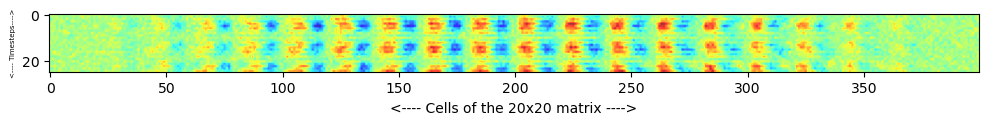

In [6]:
data_reshaped = np.reshape(data, (25,400))

plt.imshow(data_reshaped, alpha=0.8, cmap='jet')
plt.xlabel("<---- Cells of the 20x20 matrix ---->", fontsize = "10")
plt.ylabel("<---- Timesteps---->", fontsize = "5")

print("Reshaped Data : ",data_reshaped.shape)


**1) Performing SVD on the reshaped matrix,
2) Plotting the singular values and extracting significant ones**

SVD of the reshaped matrix followed by plotting of the singular values are given below:

Shape(U) =  (25, 25) Shape(s) =  (25,) Shape(Vh) =  (400, 400)


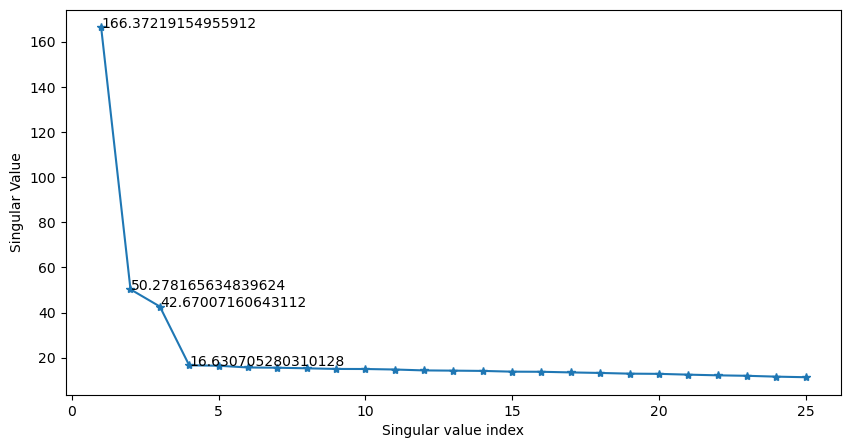

In [7]:
from scipy import linalg as la
U,s,Vh = la.svd(data_reshaped)

print('Shape(U) = ',U.shape, 'Shape(s) = ', s.shape, 'Shape(Vh) = ',Vh.shape)

x = np.arange(1,26,1)

plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(x,s,'-*')
plt.xlabel('Singular value index')
plt.ylabel('Singular Value')
for i,j in zip(x[0:4],s[0:4]):
    plt.annotate(str(j),xy=(i,j))

plt.show()

Text(0.5, 1.0, 'VT matrix')

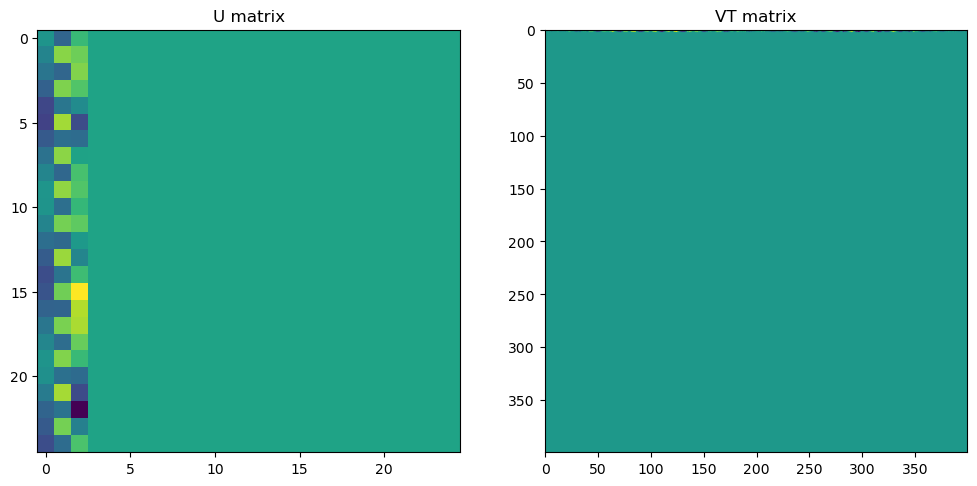

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2) 
axes[0].imshow(U)
axes[0].set_title("U matrix")
axes[1].imshow(Vh)
axes[1].set_title("VT matrix")

It can be seen that most of the magnitude lies with the top 3 eigen values, then it saturates.

The top 3 eigen values along with their magnitude contribution is given by:

In [8]:
print("Top 3 singular values", s[0:3])
magnitude_retained = np.sum((s[0:3])**2)/np.sum(s**2)
print("Magnitude contribution: ", magnitude_retained*100,"%")

Top 3 singular values [166.37219155  50.27816563  42.67007161]
Magnitude contribution:  88.08473290925461 %


**3) Top 3 singular values can be taken to plot their corresponding spatial pattern,
which would be the rows of $V^T$(reshaped back to 20x20), plotting the variation of values(scaled with the singular value) in the columns of U will give us how much weight each individual pattern has across different timesteps.**

$data_{25x400} = U_{25x25} {\sum}_{25x400} {V^T}_{400x400}$

Example: To plot most significant pattern we will take the top row from $V^T$ reshape and plot it, and to show how that pattern's contribution will change with time from t = 0 to t = 24 we will plot the values of the first column of $U$ scaled with the corresponding singular value.



(5, 20, 20) (25, 5)


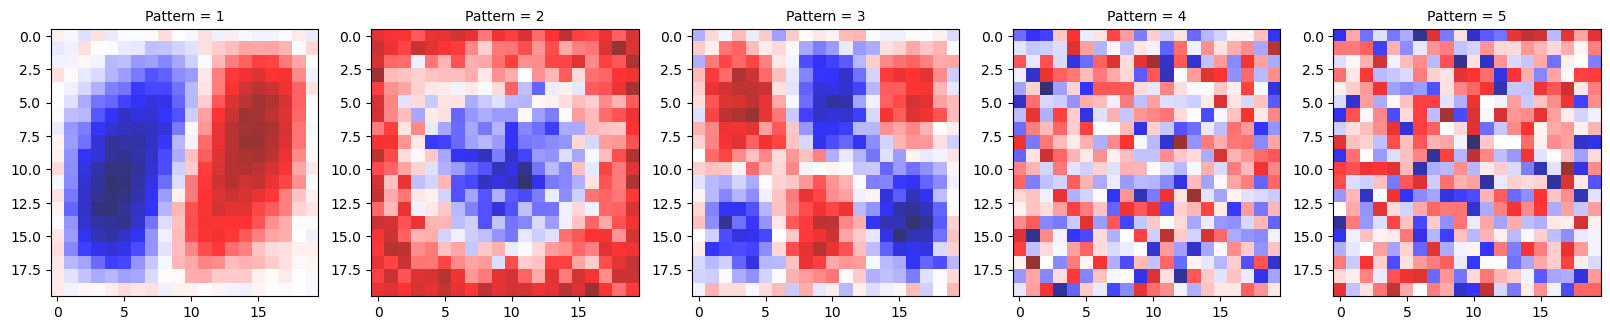

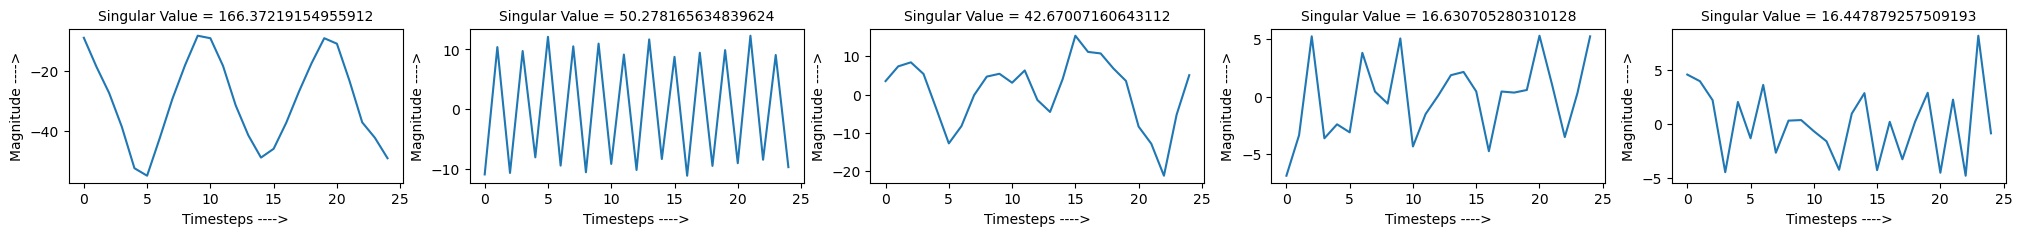

In [9]:
n_singular = 5

Vh_significant = np.reshape(Vh[0:n_singular,:], (n_singular,20,20))
U_significant = U[:,0:n_singular]
print(Vh_significant.shape, U_significant.shape)
plt.rcParams['figure.figsize'] = [20, 10]

fig, axes = plt.subplots(nrows=1, ncols=n_singular) 

timestep = 0

#Creating subplots for each timestep
n = 0
for ax in axes.flat: 
    ax.imshow(Vh_significant[n], alpha = 0.8, cmap = 'seismic') 
    ax.set_title("Pattern = " + str(n+1), fontsize = '10')
    n = n + 1
    
plt.show()

plt.rcParams['figure.figsize'] = [25, 2]
fig, axes = plt.subplots(nrows=1, ncols=n_singular)

n = 0 
for ax in axes.flat: 
    ax.plot(U[:,n]*s[n])
    ax.set_title("Singular Value = " + str(s[n]), fontsize = '10')
    ax.set_xlabel('Timesteps ---->', fontsize = '10')
    ax.set_ylabel('Magnitude ---->', fontsize = '10')
    n = n + 1
plt.show()

From pattern 4 onwards we see nothing of significance, **we will hence limit the significance upto p = 3**

**Reconstructing the data matrix using the top 3 singular values**

(25, 25) (25, 400) (400, 400)


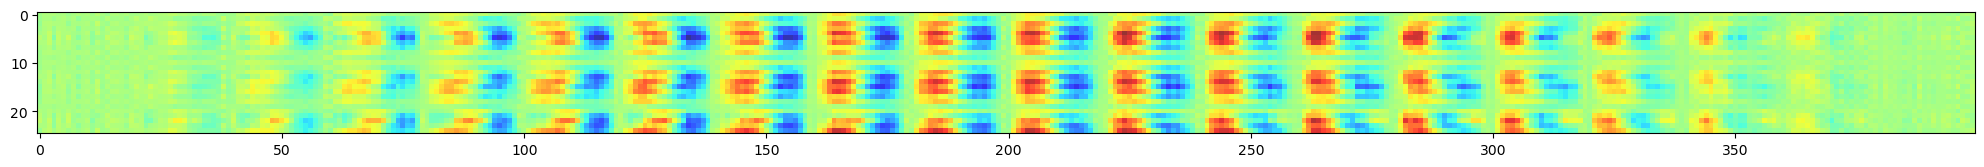

In [10]:
n_singular = 3

U_modified = U
Vh_modified = Vh

# Setting all non-significant values to 0 
for i in range(0,25):
    for j in range(n_singular,25):
        U_modified[i,j] = 0

for i in range(0,400):
    for j in range(n_singular,400):
        Vh_modified[j,i] = 0

# The singular value matrix is constructed
sigma_modified = np.zeros((25,400))
for i in range(0,n_singular):
    sigma_modified[i,i] = s[i]

print(np.shape(U_modified), np.shape(sigma_modified), np.shape(Vh_modified))
data_recon = U_modified@sigma_modified@Vh_modified

plt.imshow(data_recon, alpha=0.8, cmap='jet')
plt.show()

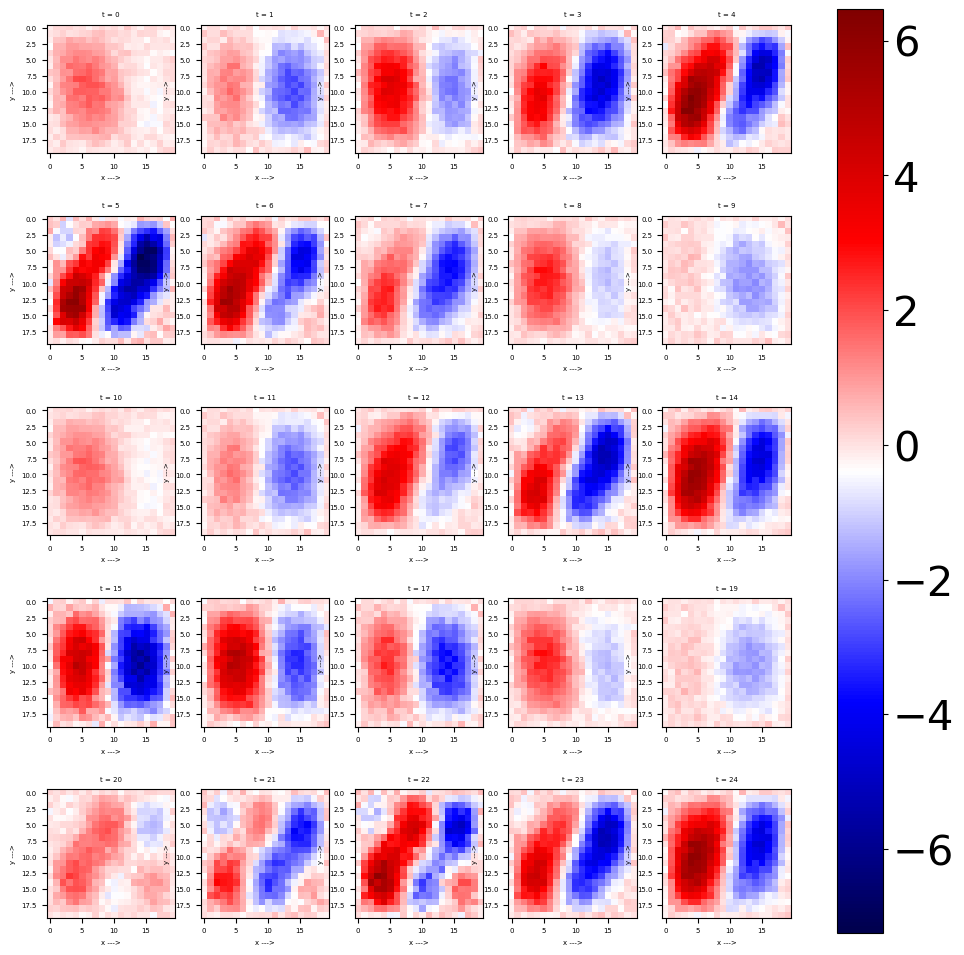

In [11]:
data_recon = np.reshape(data_recon,(25,20,20))
plt.rcParams['figure.figsize'] = [12, 12]

fig, axes = plt.subplots(nrows=5, ncols=5) 

timestep = 0

#Creating subplots for each timestep
for ax in axes.flat: 
    im = ax.imshow(data_recon[timestep],
                   vmin=np.min(data_recon), 
                   vmax=np.max(data_recon), 
                   cmap = 'seismic') 
    ax.tick_params(axis='both', which='major', labelsize=5)
    ax.tick_params(axis='both', which='minor', labelsize=5)
    ax.set_title("t = " + str(timestep), fontsize = '5')
    ax.set_xlabel("x --->",fontsize = "5")
    ax.set_ylabel("y --->",fontsize = "5")
    timestep = timestep+1
  
cbar = plt.colorbar(im, ax=axes.ravel().tolist()) 
cbar.ax.tick_params(labelsize=30)
plt.show()

Taking the singular values p = 3 while excluding the rest corresponds to: 1) keeping the signal intact while removing the noise in the data which may have come from experimental faults or limited accuracy of the methods of measurement. In short it helps us to find the dominant processes.
2) Compressing the data and reducing the dimensions required to explain it.

We can actually find this dipolar pressure pattern in the El Nino phenomenon where there is lower pressure over Tahiti and higher pressure over Darwin, Australia.